In [4]:
# IMPORTING MODULES
import glob
import importlib
import heartpy as hp
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import scipy.signal as ss
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)

import tools.data_reader_apd as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing

from scipy.fft import fft, fftfreq, fftshift

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

In [ ]:
# EXAMPLES ON HOW TO PLOT FFT USING DIFFERENT METHODS (calculate_fft, calculate_fft_1d, calculate_group_metric)

importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

convert_sr = False
is_clean_ecg = False
task = dr.Tasks.BASELINE
data_type = dr.DataTypes.ECG
phase = dr.Phases.BASE_REST
fs = 250.0
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr)
data = ha_ecg[0]
data = np.reshape(data, (data.size, 1))
freq, fft = preprocessing.calculate_fft(data, fs, feature_dim=f_dim)
dt.plot_fft_data(freq[1:], fft[0][1:], data_type="ECG BASELINE REST", labels="HA")



freq, fft = preprocessing.calculate_fft_1d(data, fs)
dt.plot_fft_data(freq[1:], fft[1:], data_type="ECG BASELINE REST", labels="HA")


print("FROM BATCH CALCULATED FFT")
freq, ha_ecg_fft = preprocessing.calculate_group_metric("HA", task, data_type, phase, "fft")
dt.plot_fft_data(freq[1:], ha_ecg_fft[1:, 0, 0], data_type="ECG BASELINE REST", labels="HA")



In [ ]:
# FEATURE EXTRACTION WITH HEARTPY - BPM, RMSSD, SDNN
# WORKS
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import heartpy as hp


convert_sr = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
is_clean_ecg = False
data_type = dr.DataTypes.ECG
measure = "bpm"
# measure = "rmssd"
# measure = "sdnn"
fs = 250.0
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]


for task in tasks:
    if task == dr.Tasks.BASELINE:
        phases = [dr.Phases.BASE_REST]
    elif task == dr.Tasks.BUGS:
        phases = [dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK]
    else:
        phases = [dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK]
    for phase in phases:
        ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr, is_clean_ecg)
        la = []
        ha = []
        print(f"LA {phase}")
        for i in range(len(la_ecg)):
            try:
                subject = la_ecg[i].iloc[0, 0]
                data = la_ecg[i].iloc[:, -1].to_numpy().flatten()
                if data.size == 0:
                    print(f"LA index {i} has value None")
                    value = np.asarray([0.0])
                else:
                    data = data.flatten()
                    ecg_features = preprocessing.get_ecg_metrics(data, fs)
            except Exception as e:
                print(f"LA index {i} has value None")
                value = np.asarray([0.0])

            value = ecg_features[measure]
            value = np.insert(value, 0, subject)
            la.append(value)

        print(f"HA {phase}")
        for i in range(len(ha_ecg)):
            try:
                subject = ha_ecg[i].iloc[0, 0]
                data = ha_ecg[i].iloc[:, -1].to_numpy().flatten()
                if data.size == 0:
                    print(f"HA index {i} has value None")
                    value = np.asarray([0.0])
                else:
                    data = data.flatten()
                    ecg_features = preprocessing.get_ecg_metrics(data, fs)
            except Exception:
                print(f"HA index {i} has value None")
                value = np.asarray([0.0])

            value = ecg_features[measure]
            value = np.insert(value, 0, subject)
            ha.append(value)

        # bpm_array = np.array([la, ha]).transpose()
        ha_df = pd.DataFrame(ha)
        la_df = pd.DataFrame(la)

        ha_file = os.path.join(dr.Paths.METRICS, f"{measure}_{phase}_ha.csv")
        la_file = os.path.join(dr.Paths.METRICS, f"{measure}_{phase}_la.csv")
        with open(ha_file, "w+") as f:
            ha_df.to_csv(f)
        with open(la_file, "w+") as f:
            la_df.to_csv(f)


In [ ]:
# FEATURE EXTRACTION - HF RR, LF RR
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)


convert_sr = False
is_clean_ecg = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
data_type = dr.DataTypes.ECG
# measure = "hf_rr"
measure = "lf_rr"
fs = preprocessing.FS_DICT[data_type]
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]


for task in tasks:
    if task == dr.Tasks.BASELINE:
        phases = [dr.Phases.BASE_REST]
    elif task == dr.Tasks.BUGS:
        phases = [dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK]
    else:
        phases = [dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK]
    for phase in phases:
        ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr, is_clean_ecg)
        la = []
        ha = []
        print(f"LA {phase}")
        for i in range(len(la_ecg)):
            subject = la_ecg[i].iloc[0, 0]
            try:
                data = la_ecg[i].iloc[:, -1]
                if data.size == 0:
                    value = np.asarray([0.0])
                else:
                    if measure == "hf_rr":
                        value = preprocessing.get_hf_rr(data)
                    else:
                        value = preprocessing.get_lf_rr(data)
                        # print(value)
                    if value is None: 
                        print(f"LA index {i} has value None")
                        value = np.asarray([0.0])
            except Exception:
                print(f"LA index {i} has value None")
                value = np.asarray([0.0])

            value = np.insert(value, 0, subject)
            la.append(value)

        print(f"HA {phase}")
        for i in range(len(ha_ecg)):
            subject = ha_ecg[i].iloc[0, 0]
            try:
                data = ha_ecg[i].iloc[:, -1]
                if data.size == 0:
                    value = np.asarray([0.0])
                else:
                    if measure == "hf_rr":
                        value = preprocessing.get_hf_rr(data)
                    else:
                        value = preprocessing.get_lf_rr(data)
                    if value is None: 
                        print(f"HA index {i} has value None")
                        value = np.asarray([0.0])
            except Exception:
                print(f"HA index {i} has value None")
                value = np.asarray([0.0])

            value = np.insert(value, 0, subject)
            ha.append(value)

        ha_df = pd.DataFrame(ha)
        la_df = pd.DataFrame(la)

        ha_file = os.path.join(dr.Paths.METRICS, f"{measure}_{phase}_ha.csv")
        la_file = os.path.join(dr.Paths.METRICS, f"{measure}_{phase}_la.csv")
        with open(ha_file, "w+") as f:
            ha_df.to_csv(f)
        with open(la_file, "w+") as f:
            la_df.to_csv(f)


In [11]:
# FEATURE EXTRACTION - EDA
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

from biosppy.signals import eda
from heartpy.preprocessing import scale_data


convert_sr = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
data_type = dr.DataTypes.EDA
# measure = "mean_SCL"
measure = "SCR_rate"
fs = preprocessing.FS_DICT[data_type]
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]


for task in tasks:
    if task == dr.Tasks.BASELINE:
        phases = [dr.Phases.BASE_REST]
    elif task == dr.Tasks.BUGS:
        phases = [dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK]
    else:
        phases = [dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK]
    for phase in phases:
        ha_eda, la_eda = preprocessing.load_data(task, data_type, phase, convert_sr)
        la = []
        ha = []
        print(f"LA {phase}")
        for i in range(len(la_eda)):
            try:
                subject = la_eda[i].iloc[0, 0]
                eda_signal = la_eda[i].iloc[:, -1]
                if measure == "mean_SCL":
                    value = preprocessing.get_mean_SCL(eda_signal)
                else:
                    value = preprocessing.get_SCR_rate(eda_signal)
                if value is None: 
                    print(f"LA index {i} has value None")
                    value = np.asarray([0.0])
            except Exception:
                print(f"LA index {i} has value None")
                value = np.asarray([0.0])

            value = np.insert(value, 0, subject)
            la.append(value)

        print(f"HA {phase}")
        for i in range(len(ha_eda)):
            try:
                subject = ha_eda[i].iloc[0, 0]
                eda_signal = ha_eda[i].iloc[:, -1]
                if measure == "mean_SCL":
                    value = preprocessing.get_mean_SCL(eda_signal)
                else:
                    value = preprocessing.get_SCR_rate(eda_signal)
                if value is None: 
                    print(f"HA index {i} has value None")
                    value = np.asarray([0.0])
            except Exception:
                print(f"HA index {i} has value None")
                value = np.asarray([0.0])

            value = np.insert(value, 0, subject)
            ha.append(value)

        ha_df = pd.DataFrame(ha)
        la_df = pd.DataFrame(la)

        ha_file = os.path.join(dr.Paths.METRICS, f"{measure}_{phase}_ha.csv")
        la_file = os.path.join(dr.Paths.METRICS, f"{measure}_{phase}_la.csv")
        with open(ha_file, "w+") as f:
            ha_df.to_csv(f)
        with open(la_file, "w+") as f:
            la_df.to_csv(f)


LA Baseline_Rest
HA Baseline_Rest
LA BugBox_Relax
HA BugBox_Relax
LA BugBox_Anticipate
HA BugBox_Anticipate
LA BugBox_Exposure
LA index 2 has value None
LA index 3 has value None
LA index 13 has value None
LA index 25 has value None
HA BugBox_Exposure
HA index 1 has value None
HA index 2 has value None
HA index 13 has value None
HA index 18 has value None
HA index 20 has value None
HA index 21 has value None
LA BugBox_Break
HA BugBox_Break
LA Speech_Relax
HA Speech_Relax
LA Speech_Anticipate
HA Speech_Anticipate
LA Speech_Exposure
HA Speech_Exposure
HA index 9 has value None
HA index 25 has value None
LA Speech_Break
HA Speech_Break


6
4
3
3


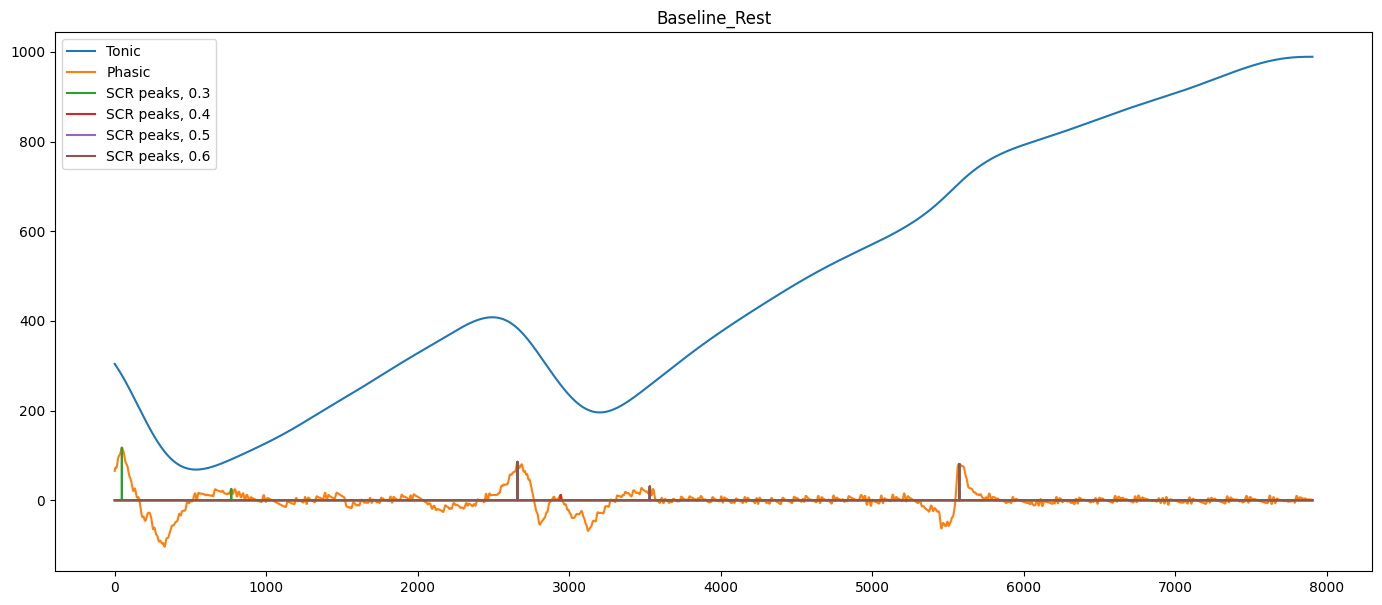

4
3
3
2


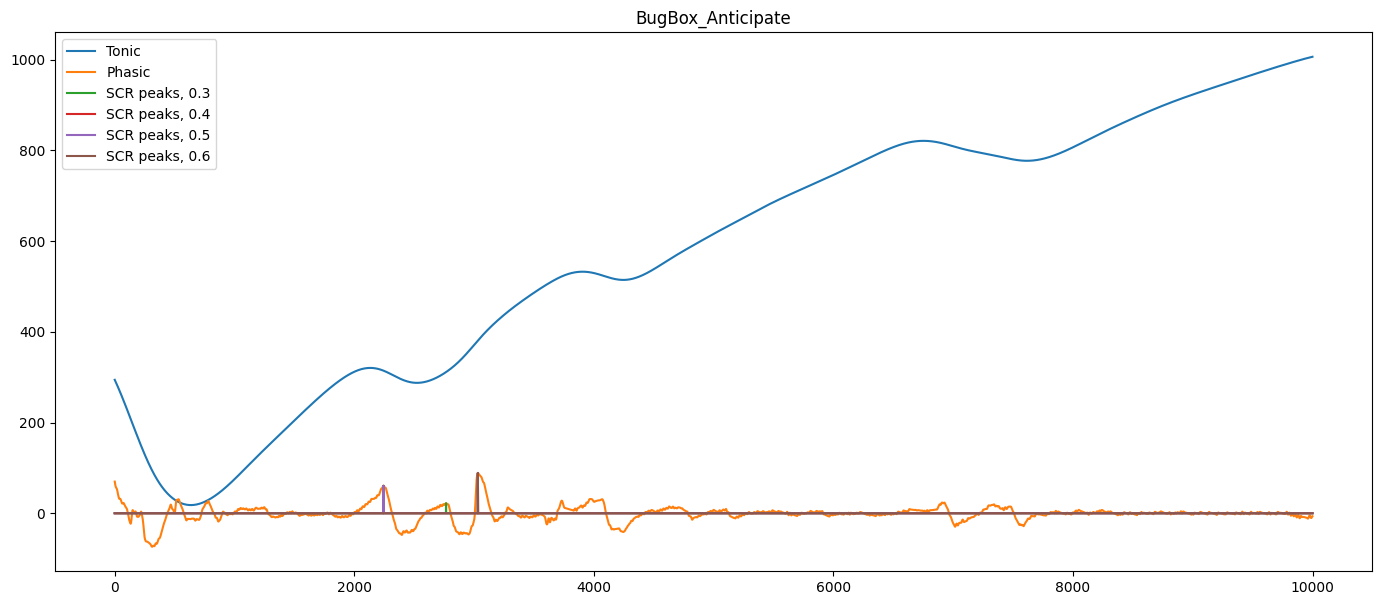

10
9
6
2


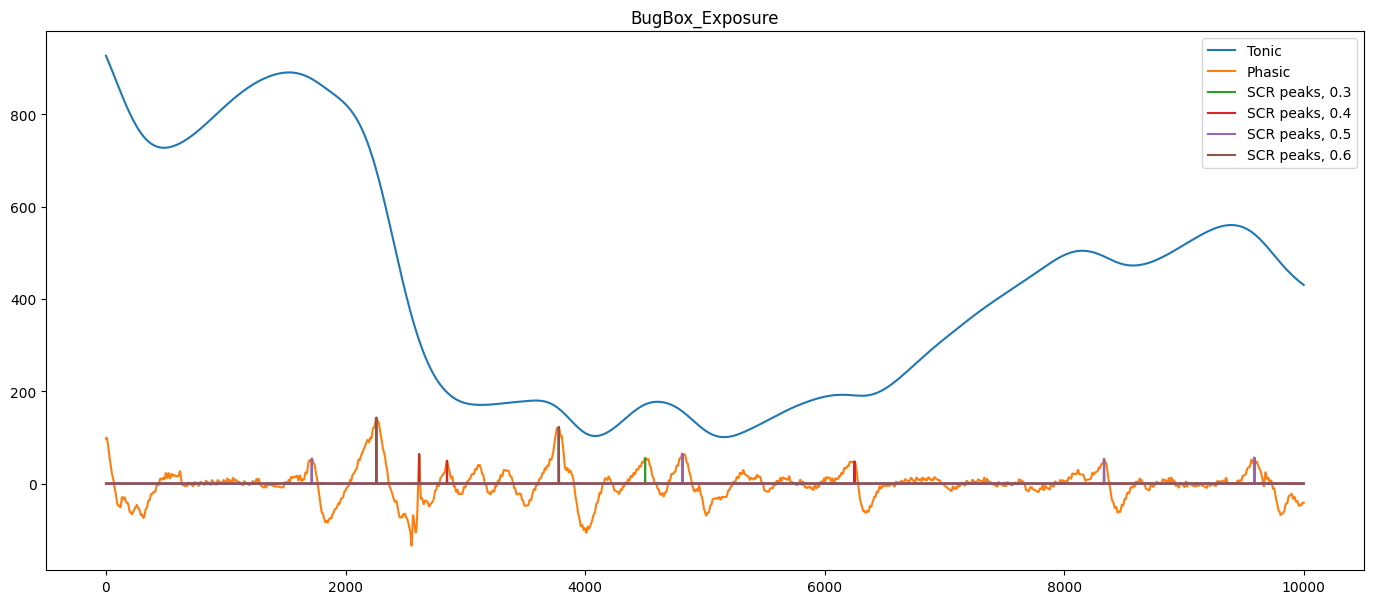

20
16
11
9


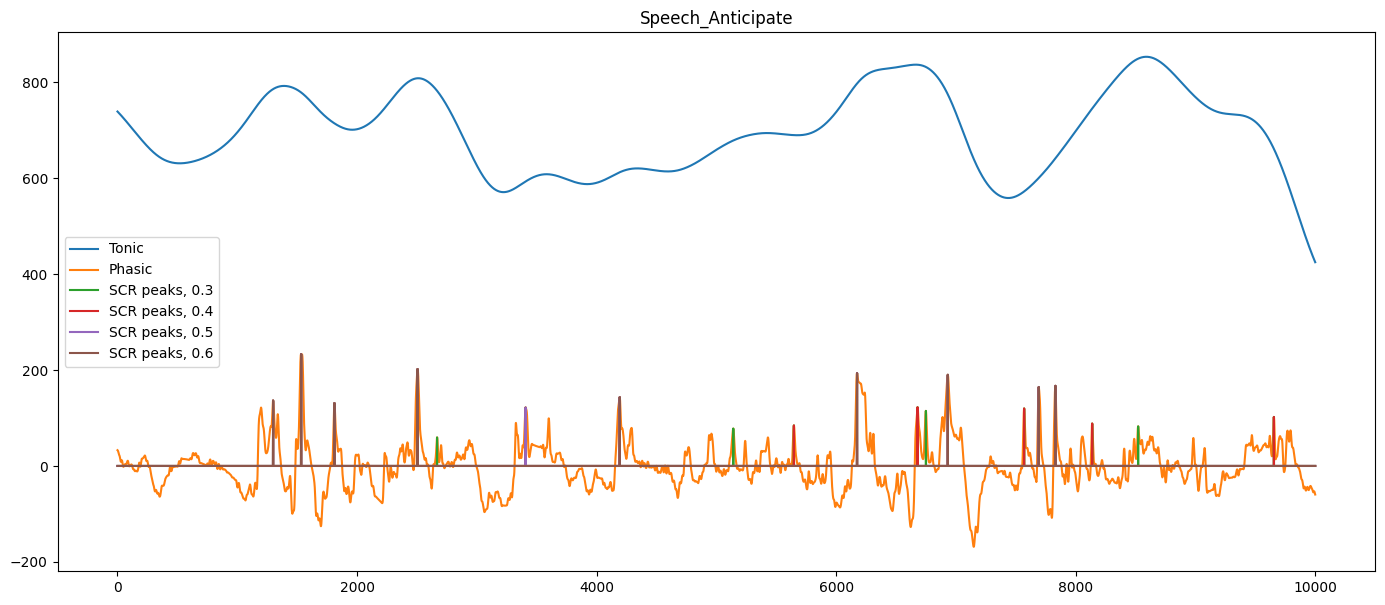

15
13
11
7


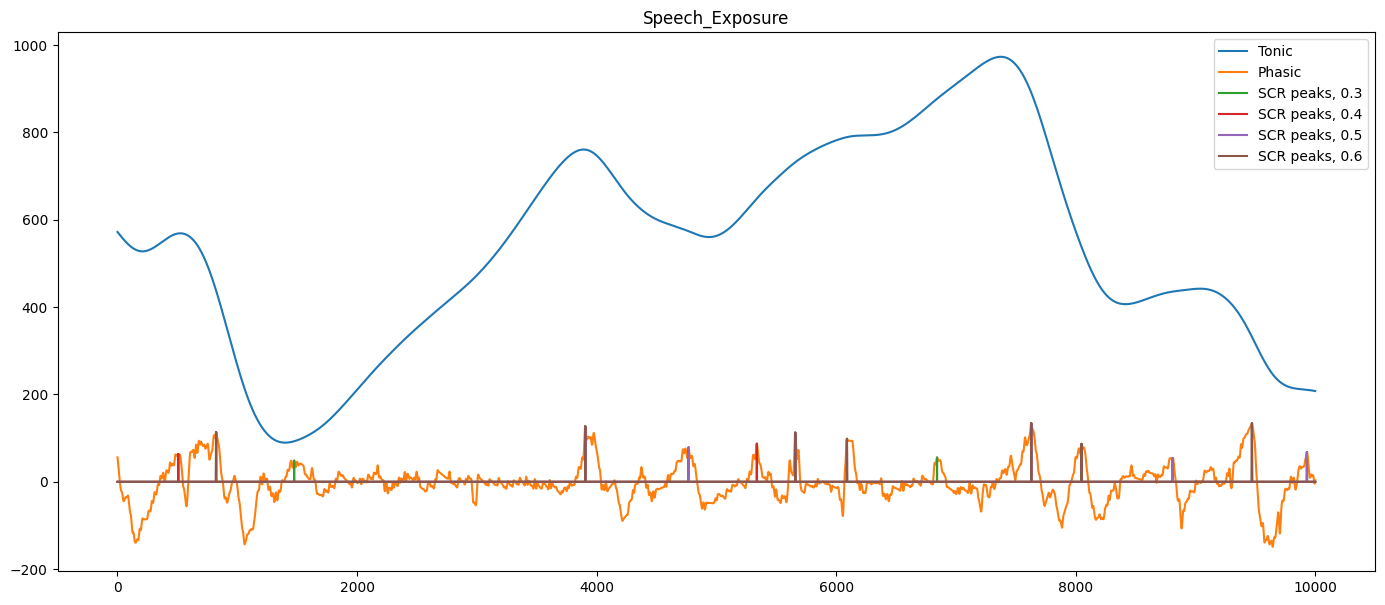

In [77]:
# EDA - TESTING
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
import samplerate
from biosppy.signals import ecg
from biosppy.signals import eda
from heartpy.preprocessing import scale_data


convert_sr = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
phase = dr.Phases.BUG_ANTICIPATE
data_type = dr.DataTypes.EDA
measure = "SCR_rate"
fs = preprocessing.FS_DICT[data_type]
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

plot_start = 0
plot_end = 10000

for task in tasks:
    if task == dr.Tasks.BASELINE:
        phases = [dr.Phases.BASE_REST]
    if task == dr.Tasks.BUGS:
        phases = [dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE]
    if task == dr.Tasks.SPEAKING:
        phases = [dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE]

    for phase in phases:
        ha_eda, la_eda = preprocessing.load_data(task, data_type, phase, convert_sr)
        eda_signal = la_eda[15].iloc[:, -1]
        eda_signal = scale_data(eda_signal)

        signals, info = nk.eda_process(eda_signal, sampling_rate=fs)
        eda_signal = signals["EDA_Clean"]
        # dt.plot_1d_data(eda_signal[plot_start:plot_end])

        peaks = signals["SCR_Peaks"].to_numpy()
        t = signals["EDA_Tonic"].to_numpy()
        p = signals["EDA_Phasic"].to_numpy()
        h = signals["SCR_Height"].to_numpy()

        peak_info = nk.eda_findpeaks(p, fs, amplitude_min=0.3)
        peak_idx = peak_info["SCR_Peaks"].astype(int)
        peak_amps = peak_info["SCR_Height"]
        peaks1 = np.zeros(p.shape)
        np.put(peaks1, peak_idx, peak_amps)
        print(len(peak_idx))

        peak_info = nk.eda_findpeaks(p, fs, amplitude_min=0.4)
        peak_idx = peak_info["SCR_Peaks"].astype(int)
        peak_amps = peak_info["SCR_Height"]
        peaks2 = np.zeros(p.shape)
        np.put(peaks2, peak_idx, peak_amps)
        print(len(peak_idx))

        peak_info = nk.eda_findpeaks(p, fs, amplitude_min=0.5)
        peak_idx = peak_info["SCR_Peaks"].astype(int)
        peak_amps = peak_info["SCR_Height"]
        peaks3 = np.zeros(p.shape)
        np.put(peaks3, peak_idx, peak_amps)
        print(len(peak_idx))

        peak_info = nk.eda_findpeaks(p, fs, amplitude_min=0.6)
        peak_idx = peak_info["SCR_Peaks"].astype(int)
        peak_amps = peak_info["SCR_Height"]
        peaks4 = np.zeros(p.shape)
        np.put(peaks4, peak_idx, peak_amps)
        print(len(peak_idx))

        plt.figure(figsize=(17, 7))
        plt.plot(t[plot_start:plot_end], label="Tonic")
        plt.plot(p[plot_start:plot_end], label="Phasic")
        plt.plot(peaks1[plot_start:plot_end], label="SCR peaks, 0.3")
        plt.plot(peaks2[plot_start:plot_end], label="SCR peaks, 0.4")
        plt.plot(peaks3[plot_start:plot_end], label="SCR peaks, 0.5")
        plt.plot(peaks4[plot_start:plot_end], label="SCR peaks, 0.6")
        plt.title(phase)
        plt.legend()
        plt.show()

In [ ]:
# FEATURE EXTRACTION -- STATISTICAL FEATURES FOR EDA
# mean, median, std, variance, IQR, RMS, skewness, kurtosis
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
import scipy
from biosppy.signals import eda
from heartpy.preprocessing import scale_data
from scipy.stats import iqr, skew, kurtosis


def rms(x):
    return np.sqrt(np.mean(x**2))

metrics = {
    "mean": np.nanmean,
    "median": np.nanmedian,
    "std": np.nanstd,
    "var": np.nanvar,
    "iqr": iqr,
    "rms": rms,
    "skew": skew,
    "kurtosis": kurtosis
}

convert_sr = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
data_type = dr.DataTypes.EDA
fs = preprocessing.FS_DICT[data_type]
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

for metric in metrics:
    for task in tasks:
        if task == dr.Tasks.BASELINE:
            phases = [dr.Phases.BASE_REST]
        elif task == dr.Tasks.BUGS:
            phases = [dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK]
        else:
            phases = [dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK]
        for phase in phases:
            ha_eda, la_eda = preprocessing.load_data(task, data_type, phase, convert_sr)
            la = []
            ha = []
            print(f"LA {phase}")
            for i in range(len(la_eda)):
                try:
                    subject = la_eda[i].iloc[0, 0]
                    eda_signal = la_eda[i].iloc[:, -1]

                    eda_signal = scale_data(eda_signal)
                    eda_signal = scipy.ndimage.median_filter(eda_signal, int(fs))  # median smoothing to reject outliers
                    eda_signal = np.convolve(eda_signal, np.ones(int(fs))/int(fs))  # mean filtering

                    # out = eda.eda(signal=eda_signal, sampling_rate=fs, show=False)
                    # eda_signal = out["filtered"]
                    signals, info = nk.eda_process(eda_signal, sampling_rate=fs)
                    eda_signal = signals["EDA_Clean"].to_numpy()
                    value = preprocessing.get_statistical_metrics(eda_signal, metrics[metric], fs)
                except Exception:
                    print(f"LA index {i} has value None")
                    value = np.asarray([0.0])

                value = np.insert(value, 0, subject)
                la.append(value)

            print(f"HA {phase}")
            for i in range(len(ha_eda)):
                try:
                    subject = ha_eda[i].iloc[0, 0]
                    eda_signal = ha_eda[i].iloc[:, -1]

                    eda_signal = scale_data(eda_signal)
                    eda_signal = scipy.ndimage.median_filter(eda_signal, int(fs))  # median smoothing to reject outliers
                    eda_signal = np.convolve(eda_signal, np.ones(int(fs))/int(fs))  # mean filtering
                    
                    # out = eda.eda(signal=eda_signal, sampling_rate=fs, show=False)
                    # eda_signal = out["filtered"]
                    signals, info = nk.eda_process(eda_signal, sampling_rate=fs)
                    eda_signal = signals["EDA_Clean"].to_numpy()
                    value = preprocessing.get_statistical_metrics(eda_signal, metrics[metric], fs)
                except Exception:
                    print(f"HA index {i} has value None")
                    value = np.asarray([0.0])

                value = np.insert(value, 0, subject)
                ha.append(value)

            ha_df = pd.DataFrame(ha)
            la_df = pd.DataFrame(la)

            ha_file = os.path.join(dr.Paths.METRICS, f"eda_{metric}_{phase}_ha.csv")
            la_file = os.path.join(dr.Paths.METRICS, f"eda_{metric}_{phase}_la.csv")
            with open(ha_file, "w+") as f:
                ha_df.to_csv(f)
            with open(la_file, "w+") as f:
                la_df.to_csv(f)


In [ ]:
# FEATURE EXTRACTION -- STATISTICAL FEATURES FOR ECG
# mean, median, std, variance, IQR, RMS, skewness, kurtosis
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import ecg
from scipy.stats import iqr, skew, kurtosis


def rms(x):
    return np.sqrt(np.mean(x**2))

metrics = {
    "mean": np.nanmean,
    "median": np.nanmedian,
    "std": np.nanstd,
    "var": np.nanvar,
    "iqr": iqr,
    "rms": rms,
    "skew": skew,
    "kurtosis": kurtosis
}

convert_sr = False
tasks = [dr.Tasks.BASELINE, dr.Tasks.BUGS, dr.Tasks.SPEAKING]
data_type = dr.DataTypes.ECG
fs = preprocessing.FS_DICT[data_type]
f_dim = preprocessing.DATA_TYPE_DIMENSIONS[data_type]

for metric in metrics:
    for task in tasks:
        if task == dr.Tasks.BASELINE:
            phases = [dr.Phases.BASE_REST]
        elif task == dr.Tasks.BUGS:
            phases = [dr.Phases.BUG_RELAX, dr.Phases.BUG_ANTICIPATE, dr.Phases.BUG_EXPOSURE, dr.Phases.BUG_BREAK]
        else:
            phases = [dr.Phases.SPEECH_RELAX, dr.Phases.SPEECH_ANTICIPATE, dr.Phases.SPEECH_EXPOSURE, dr.Phases.SPEECH_BREAK]
        for phase in phases:
            ha_ecg, la_ecg = preprocessing.load_data(task, data_type, phase, convert_sr, is_clean_ecg=False)
            la = []
            ha = []
            print(f"LA {phase}")
            for i in range(len(la_ecg)):
                try:
                    subject = la_ecg[i].iloc[0, 0]
                    ecg_signal = la_ecg[i].iloc[:, -1]
                    ecg_signal = hp.scale_data(ecg_signal)
                    ecg_signal = scipy.ndimage.median_filter(ecg_signal, int(fs))  # median smoothing to reject outliers
                    ecg_signal = np.convolve(ecg_signal, np.ones(int(fs))/int(fs))  # mean filtering
                    ecg_signal = hp.filtering.remove_baseline_wander(ecg_signal, fs)
                    out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
                    data = out["filtered"]
                    value = preprocessing.get_statistical_metrics(data, metrics[metric], fs)
                except Exception:
                    print(f"LA index {i} has value None")
                    value = np.asarray([0.0])

                value = np.insert(value, 0, subject)
                la.append(value)

            print(f"HA {phase}")
            for i in range(len(ha_ecg)):
                try:
                    subject = ha_ecg[i].iloc[0, 0]
                    ecg_signal = ha_ecg[i].iloc[:, -1]
                    ecg_signal = hp.scale_data(ecg_signal)
                    ecg_signal = scipy.ndimage.median_filter(ecg_signal, int(fs))  # median smoothing to reject outliers
                    ecg_signal = np.convolve(ecg_signal, np.ones(int(fs))/int(fs))  # mean filtering
                    ecg_signal = hp.filtering.remove_baseline_wander(ecg_signal, fs)
                    out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
                    data = out["filtered"]
                    value = preprocessing.get_statistical_metrics(data, metrics[metric], fs)
                except Exception:
                    print(f"HA index {i} has value None")
                    value = np.asarray([0.0])

                value = np.insert(value, 0, subject)
                ha.append(value)

            ha_df = pd.DataFrame(ha)
            la_df = pd.DataFrame(la)

            ha_file = os.path.join(dr.Paths.METRICS, f"ecg_{metric}_{phase}_ha.csv")
            la_file = os.path.join(dr.Paths.METRICS, f"ecg_{metric}_{phase}_la.csv")
            with open(ha_file, "w+") as f:
                ha_df.to_csv(f)
            with open(la_file, "w+") as f:
                la_df.to_csv(f)
